In [3]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torchinfo
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.datasets.imagenet import IMAGENET_DARKNET_CLASS_NAMES
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.extraction import Extraction

# Setting

In [4]:
BATCH_SIZE = 32

In [5]:
artifact_path = Path("../../artifacts/extraction")
data_path = Path("F://imagenet/ILSVRC")

In [6]:
device = torch.device("cuda:0")

# data

In [7]:
IMAGE_SIZE = 224

In [8]:
# preprocess = A.Compose(
#     [
#         A.HorizontalFlip(),
#         A.ColorJitter(),
#         A.Resize(IMAGE_SIZE, IMAGE_SIZE),
#         ToTensorV2(),
#         A.Normalize(0, 1),
#     ]
# )

In [9]:
# image folder is enough for training

# dataset = torchvision.datasets.ImageFolder(
#     data_path.joinpath("Data").joinpath("CLS-LOC").joinpath("train").as_posix(),
#     transform=preprocess,
# )

In [10]:
# train_loader = DataLoader(
#     dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=get_num_workers(),
# )

In [11]:
NUM_CLASS = 1000

# model

In [12]:
model = Extraction(output_size=NUM_CLASS).to(device)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
Extraction                                    --
├─Sequential: 1-1                             --
│    └─Conv2dNormActivation: 2-1              --
│    │    └─Conv2d: 3-1                       9,408
│    │    └─BatchNorm2d: 3-2                  128
│    │    └─LeakyReLU: 3-3                    --
│    └─MaxPool2d: 2-2                         --
│    └─Conv2dNormActivation: 2-3              --
│    │    └─Conv2d: 3-4                       110,592
│    │    └─BatchNorm2d: 3-5                  384
│    │    └─LeakyReLU: 3-6                    --
│    └─MaxPool2d: 2-4                         --
├─Sequential: 1-2                             --
│    └─Conv2dNormActivation: 2-5              --
│    │    └─Conv2d: 3-7                       24,576
│    │    └─BatchNorm2d: 3-8                  256
│    │    └─LeakyReLU: 3-9                    --
│    └─Conv2dNormActivation: 2-6              --
│    │    └─Conv2d: 3-10                      294

we will show how to convert from darknet weights, which is already trained on ImageNet :D

In [12]:
FORCE_INVALIDATE = False

weights_path = artifact_path.joinpath("extraction.weights")
model_path = artifact_path.joinpath("extraction.pth")


if (weights_path.exists() and not model_path.exists()) or FORCE_INVALIDATE:
    from torchlake.image_classification.helpers.convertor_darknet import DarkNetConvertor
    convertor = DarkNetConvertor()
    remaining_bits = convertor.run(weights_path, model)
    
    assert remaining_bits == 0, "still bits not transferred"
    
    torch.save(model.state_dict(), model_path)

In [13]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [15]:
# debug here
from torchlake.common.utils.image import load_image
img = load_image("F://imagenet/ILSVRC/Data/CLS-LOC/test/ILSVRC2012_test_00000002.JPEG", is_numpy=True)
img = test_preprocess(image=img)["image"]
img = img.unsqueeze_(0).cuda()

In [16]:
model.eval()
with torch.no_grad():
    print(IMAGENET_DARKNET_CLASS_NAMES[model(img).argmax(1)])

magpie


# inference

In [14]:
model_path = artifact_path.joinpath("extraction.pth")

In [17]:
get_file_size(model_path)

'89.51MiB'

In [15]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

In [16]:
VAL_IMAGE_SIZE = 256

In [17]:
test_preprocess = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [18]:
from torchlake.common.datasets.imagenet import ImageNetFromXML

In [19]:
test_dataset = ImageNetFromXML(
    data_path,
    label_encode="darknet",
    transform=test_preprocess,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(NUM_CLASS, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1563/1563 [07:41<00:00,  3.39it/s]

[[28  0  0 ...  0  0  0]
 [ 0 35  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 27  0  0]
 [ 0  0  0 ...  0 44  0]
 [ 0  0  0 ...  0  0 30]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(IMAGENET_DARKNET_CLASS_NAMES[:1000], per_class_acc)

kit fox   : 0.56
English setter: 0.7
Siberian husky: 0.58
Australian terrier: 0.52
English springer: 0.88
grey whale: 0.92
lesser panda: 0.92
Egyptian cat: 0.5
ibex      : 0.92
Persian cat: 0.8
cougar    : 0.88
gazelle   : 0.6
porcupine : 0.88
sea lion  : 0.82
malamute  : 0.8
badger    : 0.86
Great Dane: 0.58
Walker hound: 0.8
Welsh springer spaniel: 0.9
whippet   : 0.72
Scottish deerhound: 0.82
killer whale: 0.92
mink      : 0.76
African elephant: 0.62
Weimaraner: 0.92
soft-coated wheaten terrier: 0.78
Dandie Dinmont: 0.78
red wolf  : 0.56
Old English sheepdog: 0.88
jaguar    : 0.7
otterhound: 0.6
bloodhound: 0.52
Airedale  : 0.82
hyena     : 0.9
meerkat   : 0.8
giant schnauzer: 0.74
titi      : 0.5
three-toed sloth: 0.98
sorrel    : 0.94
black-footed ferret: 0.7
dalmatian : 0.92
black-and-tan coonhound: 0.6
papillon  : 0.88
skunk     : 0.92
Staffordshire bullterrier: 0.68
Mexican hairless: 0.86
Bouvier des Flandres: 0.68
weasel    : 0.4
miniature poodle: 0.3
Cardigan  : 0.56
malinois

In [24]:
per_class_acc.mean()

0.71326

<BarContainer object of 1000 artists>

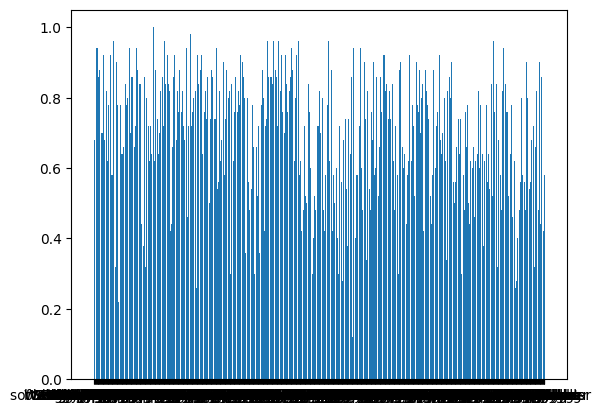

In [27]:
plt.bar(IMAGENET_DARKNET_CLASS_NAMES[:1000], per_class_acc)

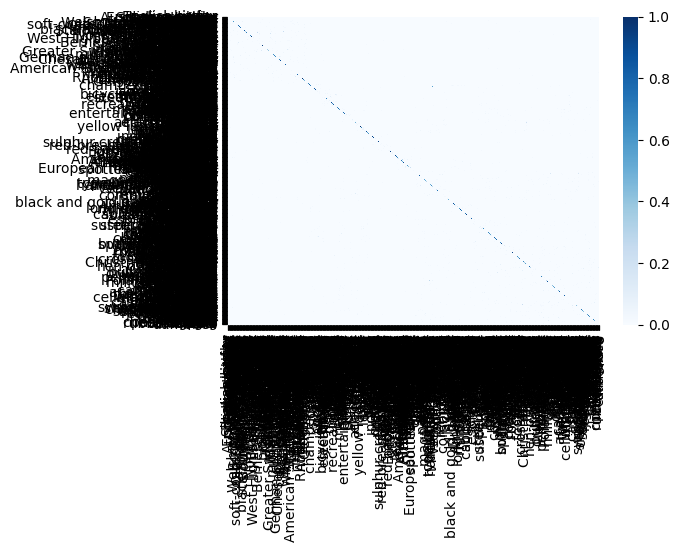

In [28]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    IMAGENET_DARKNET_CLASS_NAMES[:1000],
    "Blues",
    annot=False,
    figsize=(6, 4),
)